## LSTM with Multiple Time steps of Close Price as a Time Series Sequence

In Previous notebook, we tried different algorithms like XG Boost, Random Forest and LSTM using Extensive feature extraction where we extracted around 60 features using different Technical Indicators as well as prices of other related  Index funds like Nasdaq-100 QQQ ETF, SNP 500 Index and DJIA Index fund. Linear Regression, Random Forest and XG Boost performed really well, on an average an MAE(Mean Absolute error) of around 0.36. We also checked for Feature importance using RF. But LSTM did not perform good with these features. As expected as we did not feed any long sequence of previous data. The  Indicators for a previous day is not enough for Long short term memory. 

In this Notebook, we will focus on the Close price sequence of previous days. And we we also tune the number of lagged days to consider for prediction. With LSTM, we will try a lookback of 30 days approx 1+ months to predict the price of next day. 

### Import the Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
import numpy as np
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import cross_validate,GridSearchCV
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
#from sklearn.feature_extraction import DictVectorizer
#from sklearn.utils.multiclass import unique_labels
# import scikitplot as skplt
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline



In [2]:
file_path = 'C:\\Users\\ashok\\Desktop\\SPPO\\Streamlit Web App\\Stock Data\\IBM.csv'

In [3]:
Stock = pd.read_csv(file_path)
#best features
features_selected = ['Open','High', 'Low','QQQ_Close', 'SnP_Close', 'DJIA_Close', 'Close(t)']
df_Stock = Stock[features_selected]
df_Stock = df_Stock.iloc[:-100, :]
df_Stock = df_Stock.rename(columns={'Close(t)':'Close'})

df_Stock['Diff'] = df_Stock['Close'] - df_Stock['Open']
df_Stock['High-low'] = df_Stock['High'] - df_Stock['Low']

df_Stock.head()

,Open,High,Low,QQQ_Close,SnP_Close,DJIA_Close,Close,Diff,High-low
0,71.04,72.07,69.17,71.50,1374.62,10238.80,70.80,-0.24,2.90
1,71.32,72.55,69.17,68.23,1349.97,10089.71,71.99,0.67,3.38
2,61.64,63.15,57.50,68.01,1342.13,9975.02,60.80,-0.84,5.65
3,62.44,62.76,59.05,74.17,1388.76,10142.98,61.44,-1.00,3.71
4,60.61,61.32,60.01,75.26,1396.93,10226.59,60.37,-0.24,1.31


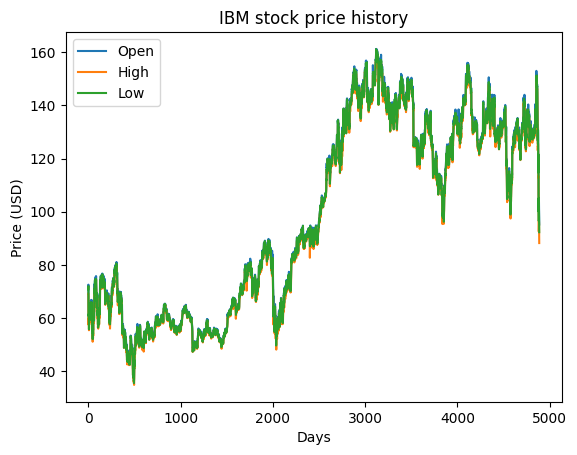

In [4]:
from matplotlib import pyplot as plt
plt.figure()
plt.plot(df_Stock["High"])
plt.plot(df_Stock["Low"])
plt.plot(df_Stock["Close"])
plt.title('IBM stock price history')
plt.ylabel('Price (USD)')
plt.xlabel('Days')
plt.legend(['Open','High','Low','Close'], loc='upper left')
plt.show()

### Create Lagged Features for getting Previous day prices for a lookback of 30 days

In [5]:
def prepare_lagged_features(df_Stock, lag_stock, lag_index):

        print('Preparing Lagged Features for Stock, Index Funds.....')
        lags = range(1, lag_stock+1)
        lag_cols= ['Close']
        df_Stock=df_Stock.assign(**{
            '{}(t-{})'.format(col, l): df_Stock[col].shift(l)
            for l in lags
            for col in lag_cols
        })

       
        lags = range(1, lag_index+1)
        lag_cols= ['QQQ_Close','SnP_Close','DJIA_Close']
        df_Stock= df_Stock.assign(**{
            '{}(t-{})'.format(col, l): df_Stock[col].shift(l)
            for l in lags
            for col in lag_cols
        })

        df_Stock = df_Stock.drop(columns=lag_cols)


        remove_lags_na = max(lag_stock, lag_index) + 1
        print('Removing NAN rows - ', str(remove_lags_na))
        df_Stock = df_Stock.iloc[remove_lags_na:,]
        return df_Stock


In [6]:
df_Stock = prepare_lagged_features(df_Stock, lag_stock = 20, lag_index = 5)
df_Stock.head()

Preparing Lagged Features for Stock, Index Funds.....
Removing NAN rows -  21


,Open,High,Low,Close,Diff,High-low,Close(t-1),Close(t-2),Close(t-3),Close(t-4),...,DJIA_Close(t-2),QQQ_Close(t-3),SnP_Close(t-3),DJIA_Close(t-3),QQQ_Close(t-4),SnP_Close(t-4),DJIA_Close(t-4),QQQ_Close(t-5),SnP_Close(t-5),DJIA_Close(t-5)
21,63.31,63.71,62.84,63.47,0.16,0.87,62.16,59.33,63.43,63.79,...,10602.95,66.00,1400.14,10834.25,66.01,1409.28,10907.06,71.61,1431.87,10952.18
22,63.47,63.83,62.28,63.39,-0.08,1.55,63.47,62.16,59.33,63.43,...,10517.25,62.56,1365.98,10602.95,66.00,1400.14,10834.25,66.01,1409.28,10907.06
23,63.31,63.59,62.68,62.68,-0.63,0.91,63.39,63.47,62.16,59.33,...,10681.06,62.66,1351.26,10517.25,62.56,1365.98,10602.95,66.00,1400.14,10834.25
24,62.72,65.39,62.68,65.03,2.31,2.71,62.68,63.39,63.47,62.16,...,10707.60,66.13,1382.95,10681.06,62.66,1351.26,10517.25,62.56,1365.98,10602.95
25,64.75,65.87,64.35,65.87,1.12,1.52,65.03,62.68,63.39,63.47,...,10656.03,67.47,1389.81,10707.60,66.13,1382.95,10681.06,62.66,1351.26,10517.25


In [7]:
df_Stock = df_Stock.drop(columns=['Open', 'High', 'Low'])

In [8]:
df_Stock= df_Stock.iloc[31:452,]
df_Stock.shape

(421, 38)

In [9]:
train=df_Stock.iloc[:340,]
test=df_Stock.iloc[340:,]

In [10]:
train.columns

Index(['Close', 'Diff', 'High-low', 'Close(t-1)', 'Close(t-2)', 'Close(t-3)',
       'Close(t-4)', 'Close(t-5)', 'Close(t-6)', 'Close(t-7)', 'Close(t-8)',
       'Close(t-9)', 'Close(t-10)', 'Close(t-11)', 'Close(t-12)',
       'Close(t-13)', 'Close(t-14)', 'Close(t-15)', 'Close(t-16)',
       'Close(t-17)', 'Close(t-18)', 'Close(t-19)', 'Close(t-20)',
       'QQQ_Close(t-1)', 'SnP_Close(t-1)', 'DJIA_Close(t-1)', 'QQQ_Close(t-2)',
       'SnP_Close(t-2)', 'DJIA_Close(t-2)', 'QQQ_Close(t-3)', 'SnP_Close(t-3)',
       'DJIA_Close(t-3)', 'QQQ_Close(t-4)', 'SnP_Close(t-4)',
       'DJIA_Close(t-4)', 'QQQ_Close(t-5)', 'SnP_Close(t-5)',
       'DJIA_Close(t-5)'],
      dtype='object')

In [11]:
Y_train= train[['Close']]
X_train=train[['Diff', 'High-low', 'Close(t-1)', 'Close(t-2)', 'Close(t-3)',
       'Close(t-4)', 'Close(t-5)', 'Close(t-6)', 'Close(t-7)', 'Close(t-8)',
       'Close(t-9)', 'Close(t-10)', 'Close(t-11)', 'Close(t-12)',
       'Close(t-13)', 'Close(t-14)', 'Close(t-15)', 'Close(t-16)',
       'Close(t-17)', 'Close(t-18)', 'Close(t-19)', 'Close(t-20)',
       'QQQ_Close(t-1)', 'SnP_Close(t-1)', 'DJIA_Close(t-1)', 'QQQ_Close(t-2)',
       'SnP_Close(t-2)', 'DJIA_Close(t-2)', 'QQQ_Close(t-3)', 'SnP_Close(t-3)',
       'DJIA_Close(t-3)', 'QQQ_Close(t-4)', 'SnP_Close(t-4)',
       'DJIA_Close(t-4)', 'QQQ_Close(t-5)', 'SnP_Close(t-5)',
       'DJIA_Close(t-5)']]



Y_test= test[['Close']]
X_test= test[['Diff', 'High-low', 'Close(t-1)', 'Close(t-2)', 'Close(t-3)',
       'Close(t-4)', 'Close(t-5)', 'Close(t-6)', 'Close(t-7)', 'Close(t-8)',
       'Close(t-9)', 'Close(t-10)', 'Close(t-11)', 'Close(t-12)',
       'Close(t-13)', 'Close(t-14)', 'Close(t-15)', 'Close(t-16)',
       'Close(t-17)', 'Close(t-18)', 'Close(t-19)', 'Close(t-20)',
       'QQQ_Close(t-1)', 'SnP_Close(t-1)', 'DJIA_Close(t-1)', 'QQQ_Close(t-2)',
       'SnP_Close(t-2)', 'DJIA_Close(t-2)', 'QQQ_Close(t-3)', 'SnP_Close(t-3)',
       'DJIA_Close(t-3)', 'QQQ_Close(t-4)', 'SnP_Close(t-4)',
       'DJIA_Close(t-4)', 'QQQ_Close(t-5)', 'SnP_Close(t-5)',
       'DJIA_Close(t-5)']]

### Scale features for LSTM Training

In [12]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(Y_train)

In [13]:
x_train, y_train = [], []
for i in range(60,len(Y_train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

### Create and fit the LSTM network

In [14]:
lstm = Sequential()
lstm.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
lstm.add(LSTM(units=50))
lstm.add(Dense(1))

lstm.compile(loss='mean_squared_error', optimizer='adam')
lstm.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
history_lstm = lstm.fit(x_train, y_train, epochs=25, batch_size=5, verbose=2)

Epoch 1/25
56/56 - 3s - 57ms/step - loss: 0.0359
Epoch 2/25
56/56 - 1s - 16ms/step - loss: 0.0096
Epoch 3/25
56/56 - 1s - 17ms/step - loss: 0.0072
Epoch 4/25
56/56 - 1s - 16ms/step - loss: 0.0067
Epoch 5/25
56/56 - 1s - 16ms/step - loss: 0.0064
Epoch 6/25
56/56 - 1s - 19ms/step - loss: 0.0056
Epoch 7/25
56/56 - 1s - 24ms/step - loss: 0.0055
Epoch 8/25
56/56 - 1s - 22ms/step - loss: 0.0050
Epoch 9/25
56/56 - 2s - 28ms/step - loss: 0.0049
Epoch 10/25
56/56 - 2s - 36ms/step - loss: 0.0047
Epoch 11/25
56/56 - 1s - 24ms/step - loss: 0.0043
Epoch 12/25
56/56 - 1s - 23ms/step - loss: 0.0044
Epoch 13/25
56/56 - 1s - 23ms/step - loss: 0.0043
Epoch 14/25
56/56 - 1s - 22ms/step - loss: 0.0040
Epoch 15/25
56/56 - 1s - 21ms/step - loss: 0.0036
Epoch 16/25
56/56 - 1s - 21ms/step - loss: 0.0042
Epoch 17/25
56/56 - 1s - 21ms/step - loss: 0.0043
Epoch 18/25
56/56 - 1s - 21ms/step - loss: 0.0034
Epoch 19/25
56/56 - 1s - 21ms/step - loss: 0.0032
Epoch 20/25
56/56 - 1s - 23ms/step - loss: 0.0035
Epoch 21/

In [16]:
history_lstm.history.keys()

dict_keys(['loss'])

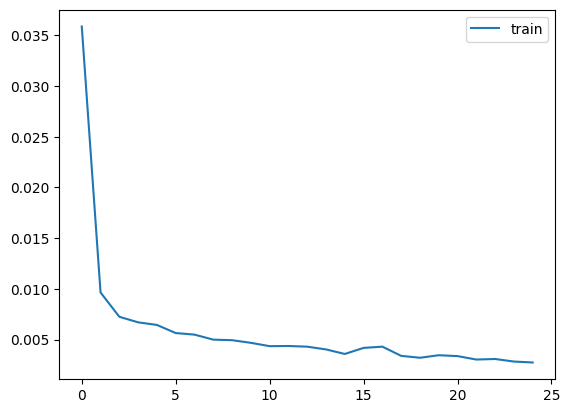

In [17]:
plt.plot(history_lstm.history['loss'], label='train')
#plt.plot(history_lstm.history['val_loss'], label='test')
plt.legend()
plt.show()

In [18]:
new_df_Stock = df_Stock['Close']

In [19]:
#predicting 246 values, using past 60 from the train data
inputs = new_df_Stock[len(new_df_Stock) - len(Y_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

In [20]:
X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = lstm.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step


In [21]:
rms=np.sqrt(np.mean(np.power((Y_test-closing_price),2)))
rms

1.7393728042132321

In [22]:
closing_price

array([[52.011307],
       [53.080883],
       [53.874363],
       [54.553673],
       [55.04768 ],
       [55.090176],
       [54.795967],
       [54.614826],
       [54.586582],
       [54.366444],
       [53.968735],
       [53.552444],
       [53.37387 ],
       [52.9763  ],
       [52.220337],
       [51.782833],
       [51.75973 ],
       [51.708717],
       [51.433937],
       [50.918503],
       [50.255318],
       [49.586506],
       [49.217495],
       [49.113743],
       [49.265793],
       [49.288628],
       [48.884155],
       [48.191254],
       [47.196438],
       [46.439297],
       [45.788128],
       [45.467987],
       [45.55313 ],
       [45.79487 ],
       [45.52002 ],
       [45.207943],
       [45.16856 ],
       [45.603477],
       [45.88671 ],
       [45.846264],
       [45.583084],
       [45.364872],
       [45.18694 ],
       [45.2625  ],
       [45.199974],
       [45.28097 ],
       [45.57163 ],
       [45.88893 ],
       [45.733505],
       [45.257618],


In [23]:
closing_price.shape

(81, 1)

In [24]:
Y_test

,Close
392,54.98
393,54.35
394,54.96
395,55.11
396,54.32
...,...
468,48.59
469,46.64
470,47.53
471,46.53


In [25]:
def get_mape(y_true, y_pred): 
        """
        Compute mean absolute percentage error (MAPE)
        """
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [26]:
print('R2 - ',round(metrics.r2_score(Y_test.Close,closing_price),2))
print('MAPE - ', round(get_mape(Y_test.Close,closing_price), 2))
print('RMSE -', round(np.sqrt(metrics.mean_squared_error(Y_test.Close,closing_price)),2))
print('MAE - ', round(metrics.mean_absolute_error(Y_test.Close,closing_price),2))


R2 -  0.76
MAPE -  8.4
RMSE - 1.74
MAE -  1.47


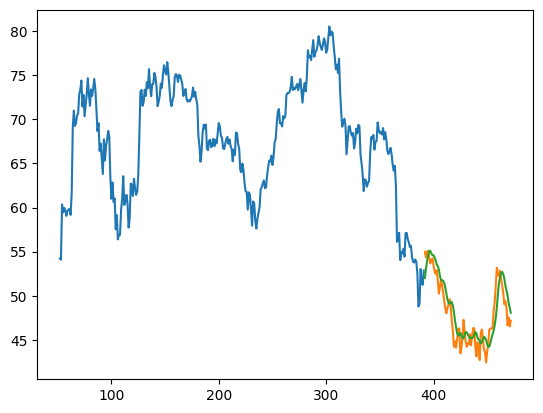

In [27]:
#for plotting
test_result=Y_test
test_result['predict']=closing_price
plt.plot(train['Close'])
plt.plot(test_result[['Close','predict']])

### Conclusion

We got Amazing results by using a 60 day lookup window for Previos Closing Prices, Index funds and by considering the difference between the High low prices.

- R2 -  0.74
- MAPE -  8.41
- RMSE - 1.81
- MAE -  1.5